<a href="https://colab.research.google.com/github/ShubhamSBhat/Bengaluru-Restaurants-Analysis/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from google.colab import drive
%matplotlib inline

import os

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,SpatialDropout1D
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:

df=pd.read_csv('/content/drive/MyDrive/zomato.csv')

In [68]:
df.drop(['url', 'address', 'phone',], axis=1, inplace=True)

In [69]:

all_ratings=[]
for name,ratings in tqdm(zip(df['name'],df['reviews_list'])):
    ratings=eval(ratings)
    for score,doc in ratings:
        if score:
            score=float(score.strip("Rated").strip())
            doc=doc.strip("Rated").strip()
            all_ratings.append([name,score,doc])
rating_Df=pd.DataFrame(all_ratings,columns=['Name','Rating','Review'])
rating_Df['Review']=rating_Df['Review'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]',"",x))
rating_Df.to_csv("Ratings.csv")

51717it [00:18, 2841.99it/s]


In [70]:
df=pd.read_csv('Ratings.csv')

In [71]:
df.head()

,Unnamed: 0,Name,Rating,Review
0,0,Jalsa,4.0,ATED\n A beautiful place to dine inThe interi...
1,1,Jalsa,4.0,ATED\n I was here for dinner with my family o...
2,2,Jalsa,2.0,ATED\n Its a restaurant near to Banashankari ...
3,3,Jalsa,4.0,ATED\n We went here on a weekend and one of u...
4,4,Jalsa,5.0,ATED\n The best thing about the place is its ...


In [72]:
df = df.drop(df[(df.Rating > 2.5) & (df.Rating < 4)].index)

In [73]:
df['Sent']=df['Rating'].apply(lambda x: 1 if int(x)>3.5 else 0)

In [74]:
##TOPIC MODELLING FOR POSITIVE COMMENTS
#Remove stopwords,lemmatize each word, create corpus and tokenize them.
stops=stopwords.words('english')
lem=WordNetLemmatizer() #Finding the root words which make sense. 
corpus=' '.join(lem.lemmatize(x) for x in df[df['Sent'] == 1]['Review'][:1000]if x not in stops)
tokens=word_tokenize(corpus)


In [75]:
#Term Frequqnecy Inverse doc Frequency(Tfidf) to vectorize the tokens.
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)

#Latent Dirichlet Allocation
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel=gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)


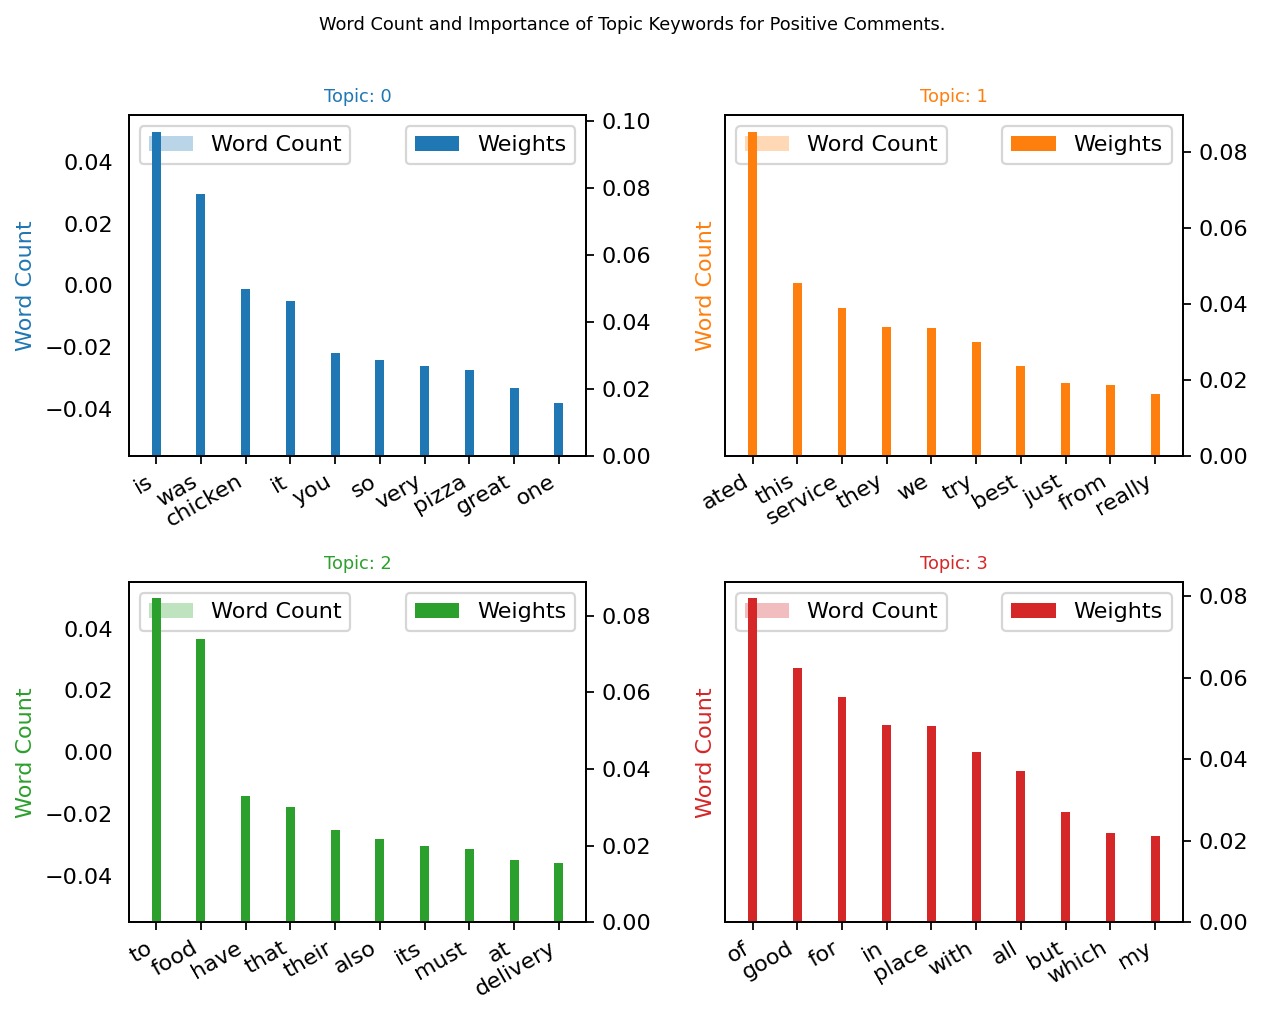

In [76]:
#Word counts of topic keywords and visualising output
counter=Counter(corpus)
topics=ldamodel.show_topics(formatted=False)
out=[]
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

df_1=pd.DataFrame(out,columns=['word','topic_id','importance','word_count'])
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_1.loc[df_1.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_1.loc[df_1.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_1.loc[df_1.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords for Positive Comments.', fontsize=8, y=1.05)
plt.show()

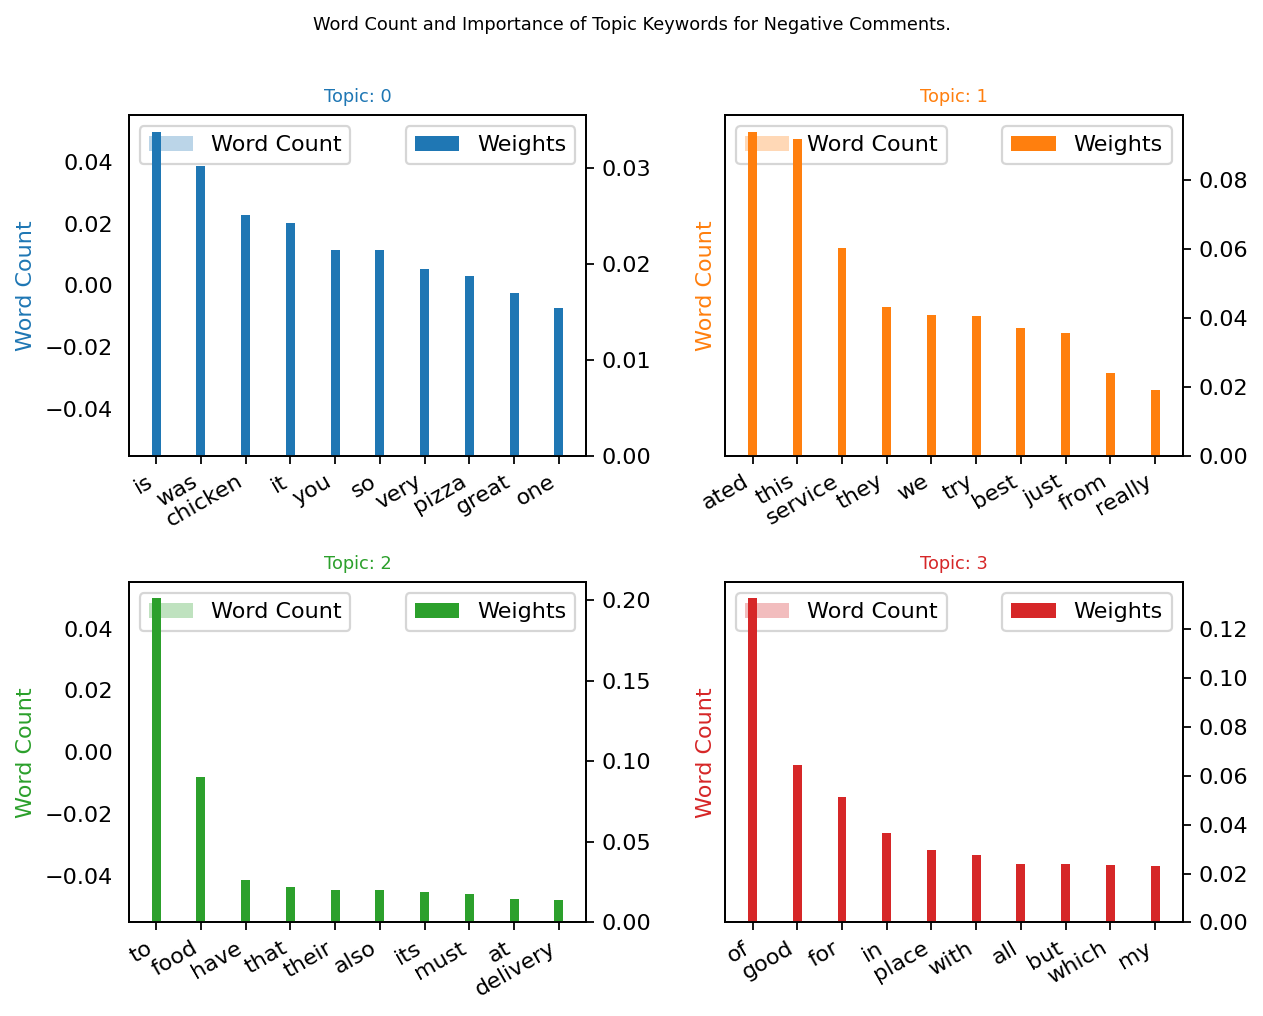

In [77]:
#TOPIC MODELLING FOR NEGATIVE COMMENTS

stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus_n=''.join(lem.lemmatize(x)for x in df[df['Sent']==0]['Review'][:1000] if x not in stops)
tokens_n=word_tokenize(corpus_n)
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens_n)
id_map_n=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data_n=vect_fit.transform(tokens_n)
gensim_corpus_n=gensim.matutils.Sparse2Corpus(vectorized_data_n,documents_columns=False)
ldamodel_n=gensim.models.ldamodel.LdaModel(gensim_corpus_n,id2word=id_map_n,num_topics=5,random_state=34,passes=25)
counter_n=Counter(corpus_n)
topics_n=ldamodel_n.show_topics(formatted=False)
out_n=[]
for i,topic in topics_n:
    for word,weight in topic:
        out_n.append([word,i,weight,counter_n[word]])

df_2=pd.DataFrame(out_n,columns=['word','topic_id','importance','word_count'])
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_2.loc[df_2.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_2.loc[df_2.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_1.loc[df_1.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords for Negative Comments.', fontsize=8, y=1.05)
plt.show()


In [78]:

#Reviews in 2D Space

stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=[]
for review in tqdm(df['Review'][:10000]):
    words=[]
    for x in word_tokenize(review):
        x=lem.lemmatize(x.lower())
        if x not in stops:
            words.append(x)
    corpus.append(words)

100%|██████████| 10000/10000 [00:03<00:00, 2576.66it/s]


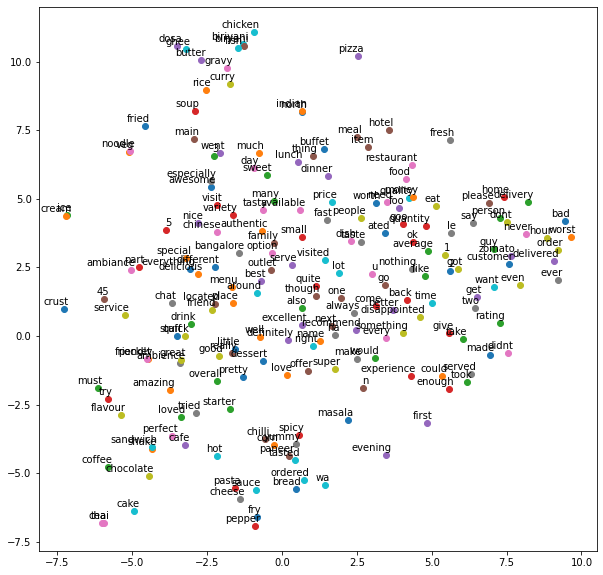

None


In [79]:
#word2vec to rep each word as a vector
model=word2vec.Word2Vec(corpus,size=100,window=20,min_count=200,workers=4)

#TSNE model
def tsne_model(model):
    labels=[]
    tokens=[]
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    tsne_model=TSNE(perplexity=40,n_components=2,init='pca',n_iter=2500,random_state=23)
    new_values=tsne_model.fit_transform(tokens)

    x,y=[],[]
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(10,10))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i],y[i]),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

print(tsne_model(model))

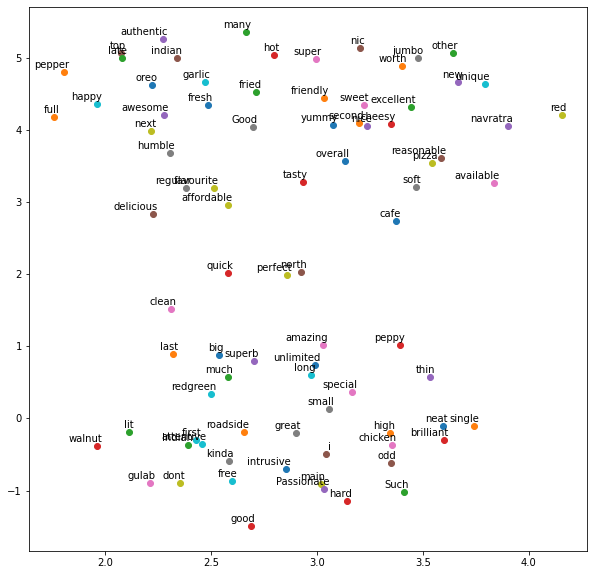

None


In [80]:
#TSNE of adjectives used in positive reviews
positive=df[df['Rating']>4.8]['Review'][:750]
negative=df[df['Rating']<2.5]['Review'][:2000]

def return_corpus(df):

    corpus=[]
    for review in df:
        tagged=nltk.pos_tag(word_tokenize(review))
        adj=[]
        for x in tagged:
            if x[1]=='JJ':
                adj.append(x[0])
        corpus.append(adj)
    return corpus

corpus_positive=return_corpus(positive)
model_positive=word2vec.Word2Vec(corpus_positive,size=100,min_count=10,window=20,workers=4)
print(tsne_model(model_positive))




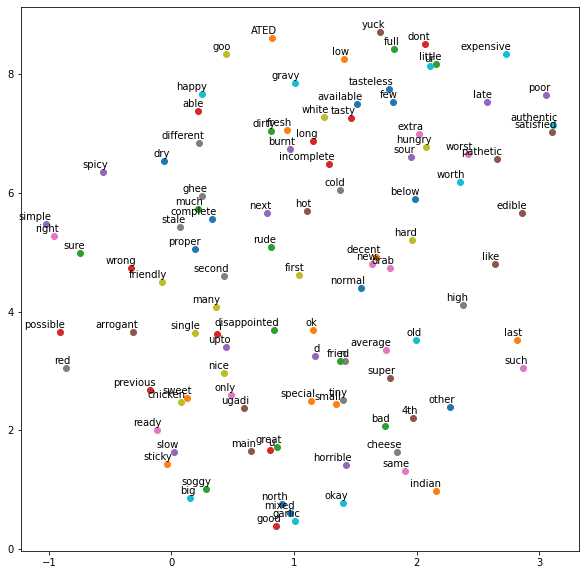

None


In [81]:
#TSNE of adjectives in negative reviews
corpus_negative=return_corpus(negative)
model_negative=word2vec.Word2Vec(corpus_negative,size=100,min_count=10,window=20,workers=4)
print(tsne_model(model_negative))

In [82]:



#Map reviews to positive and negative on the basis of the ratings provided by each user.
df=pd.read_csv('Ratings.csv')
df['Sent']=df['Rating'].apply(lambda x: 1 if int(x)>3.5 else 0)
df['Review']=df['Review'].astype('str')

#Tokenize the data and vectorize the reviews to be fed into the model
tokenizer=Tokenizer(num_words=3000,split=' ')
tokenizer.fit_on_texts(df['Review'].values)
X=pad_sequences(tokenizer.texts_to_sequences(df['Review'].values))

#Model prep
model=Sequential()
model.add(Embedding(3000,32,input_length=X.shape[1]))
model.add(LSTM(32,dropout=0.33,recurrent_dropout=0.2))
#model.add(LSTM(16,dropout=0.1,recurrent_dropout=0.1))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 195, 32)           96000     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 104,386
Trainable params: 104,386
Non-trainable params: 0
_________________________________________________________________
None


In [83]:


#Train-Test Split
Y=pd.get_dummies(df['Sent'].astype(int)).values #used for one-hot encoding
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(884378, 195) (884378, 2)
(435590, 195) (435590, 2)


Epoch 1/5
371/371 - 330s - loss: 0.3589 - accuracy: 0.8447 - val_loss: 0.2830 - val_accuracy: 0.8909 - 330s/epoch - 890ms/step
Epoch 2/5
371/371 - 332s - loss: 0.2750 - accuracy: 0.8918 - val_loss: 0.2603 - val_accuracy: 0.8974 - 332s/epoch - 895ms/step
Epoch 3/5
371/371 - 339s - loss: 0.2537 - accuracy: 0.9004 - val_loss: 0.2388 - val_accuracy: 0.9081 - 339s/epoch - 914ms/step
Epoch 4/5
371/371 - 355s - loss: 0.2357 - accuracy: 0.9087 - val_loss: 0.2220 - val_accuracy: 0.9151 - 355s/epoch - 956ms/step
Epoch 5/5
371/371 - 359s - loss: 0.2219 - accuracy: 0.9145 - val_loss: 0.2141 - val_accuracy: 0.9194 - 359s/epoch - 967ms/step
2/2 - 0s - loss: 0.2176 - accuracy: 0.9145 - 129ms/epoch - 64ms/step
273/273 - 16s - loss: 0.2146 - accuracy: 0.9194 - 16s/epoch - 58ms/step
Score on validation set: 0.22
Accuracy of validation set: 0.91
Score on test set: 0.21
Accuracy of test set: 0.92


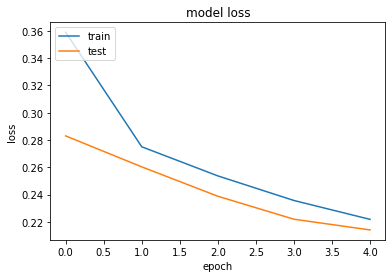

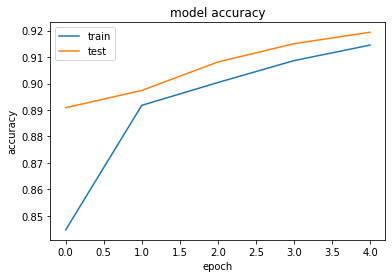

In [84]:

history=model.fit(X_train,Y_train,verbose=2,batch_size=1600,epochs=5,validation_split=0.33)

#Choosing a certain validation size
valid=2000 #Validating on 2000 rows of the test set
X_validate=X_train[-valid:]
Y_validate=Y_train[-valid:]
score,acc=model.evaluate(X_validate,Y_validate,verbose=2,batch_size=1600)
score_test,acc_test=model.evaluate(X_test,Y_test,verbose=2,batch_size=1600)
print("Score on validation set: %0.2f"%(score))
print("Accuracy of validation set: %0.2f"%(acc))
print("Score on test set: %0.2f"%(score_test))
print("Accuracy of test set: %0.2f"%(acc_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()